## Hierarchical Risk Parity - Simple Backtesting

In [1]:
import pandas as pd
import numpy as np
import hierarchical_risk_parity as hrp

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [2]:
data_provider = DataProvider()
df_prices, benchmark = data_provider.get_etf_data()
df_returns = df_prices.pct_change().dropna()
benchmark_returns = benchmark.pct_change().dropna()

### Helper methods

In [3]:
def get_weights(returns_fit):
    weights_HRP = hrp.compute_HRP_weights(returns_fit)

    weights_HRP_denoise_v1 = hrp.compute_HRP_weights(
        returns_fit, denoise_method=1)
    weights_HRP_denoise_v1.name = 'HRP_denoise_v1'

    weights_HRP_denoise_v2 = hrp.compute_HRP_weights(
        returns_fit, denoise_method=2)
    weights_HRP_denoise_v2.name = 'HRP_denoise_v2'

    weights_MV = hrp.compute_minimum_variance_weights(returns_fit)
    weights_RP = hrp.compute_risk_parity_weights(returns_fit)
    weights_unif = hrp.compute_unif_weights(returns_fit)

    weights = weights_HRP.to_frame()
    weights = weights.join(weights_HRP_denoise_v1)
    weights = weights.join(weights_HRP_denoise_v2)
    weights = weights.join(weights_MV)
    weights = weights.join(weights_RP)
    weights = weights.join(weights_unif)
    return weights

In [4]:
def daily_to_annual_returns(daily_returns):
    tot_ret = (daily_returns + 1).prod() - 1

    init_date = daily_returns.index[0]
    end_date = daily_returns.index[-1]
    fyears = (end_date - init_date) / pd.Timedelta(days=365, hours=6)

    anual_ret = np.power(tot_ret + 1, 1/fyears) - 1
    return anual_ret

In [5]:
years = list(np.arange(df_prices.index[0].year, df_prices.index[-1].year))
periods = []
for y in years:
    for m in range(12):
        periods.append(f'{y}-{(m+1):02d}')

for m in range(df_prices.index[-1].month):
    periods.append(f'{df_prices.index[-1].year}-{(m+1):02d}')

periods[:5]

['1999-01', '1999-02', '1999-03', '1999-04', '1999-05']

### Testing simple monthly rebalancing with capital accumulation

In [4]:
def get_portfolios_daily_value(available_capital, prices, weights):
    portfolios_daily_value = pd.DataFrame(columns=weights.columns)
    for m in range(weights.shape[1]):
        weights_method = weights.iloc[:, m]
        
        # Using capital from the end of the previous period
        capital = available_capital.iloc[m]
        num_part = (capital*weights_method)/prices.iloc[0]
        portfolio = prices.mul(num_part).sum(axis=1)
        portfolios_daily_value[weights_method.name] = portfolio

    return portfolios_daily_value

In [8]:
methods = ['HRP', 'HRP_denoise_v1', 'HRP_denoise_v2',  'MV', 'RP', 'unif']
df_portfolio = pd.DataFrame(columns=methods, index=df_prices.index)

initial_capital = 100000
df_portfolio.loc[periods[0]].iloc[-1, :] = initial_capital

for p in range(len(periods)-1):
    if p > periods.index('2022-03'):
        returns_fit = df_returns.loc[periods[p]].drop(columns='Russia')
        weights = get_weights(returns_fit)
        weights.loc['Russia', :] = 0
        weights = weights.sort_index()
    else:
        returns_fit = df_returns.loc[periods[p]]
        weights = get_weights(returns_fit)

    prices_period = df_prices.loc[periods[p+1]]
    available_capital = df_portfolio.dropna().iloc[-1]
    portfolioValues = get_portfolios_daily_value(
        available_capital, prices_period, weights)
    df_portfolio.loc[portfolioValues.index, :] = portfolioValues

C:\Users\lukas\AppData\Local\Temp\ipykernel_19304\4007886365.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  portfolio_returns = df_portfolio_monthly.pct_change().dropna()


<Axes: >

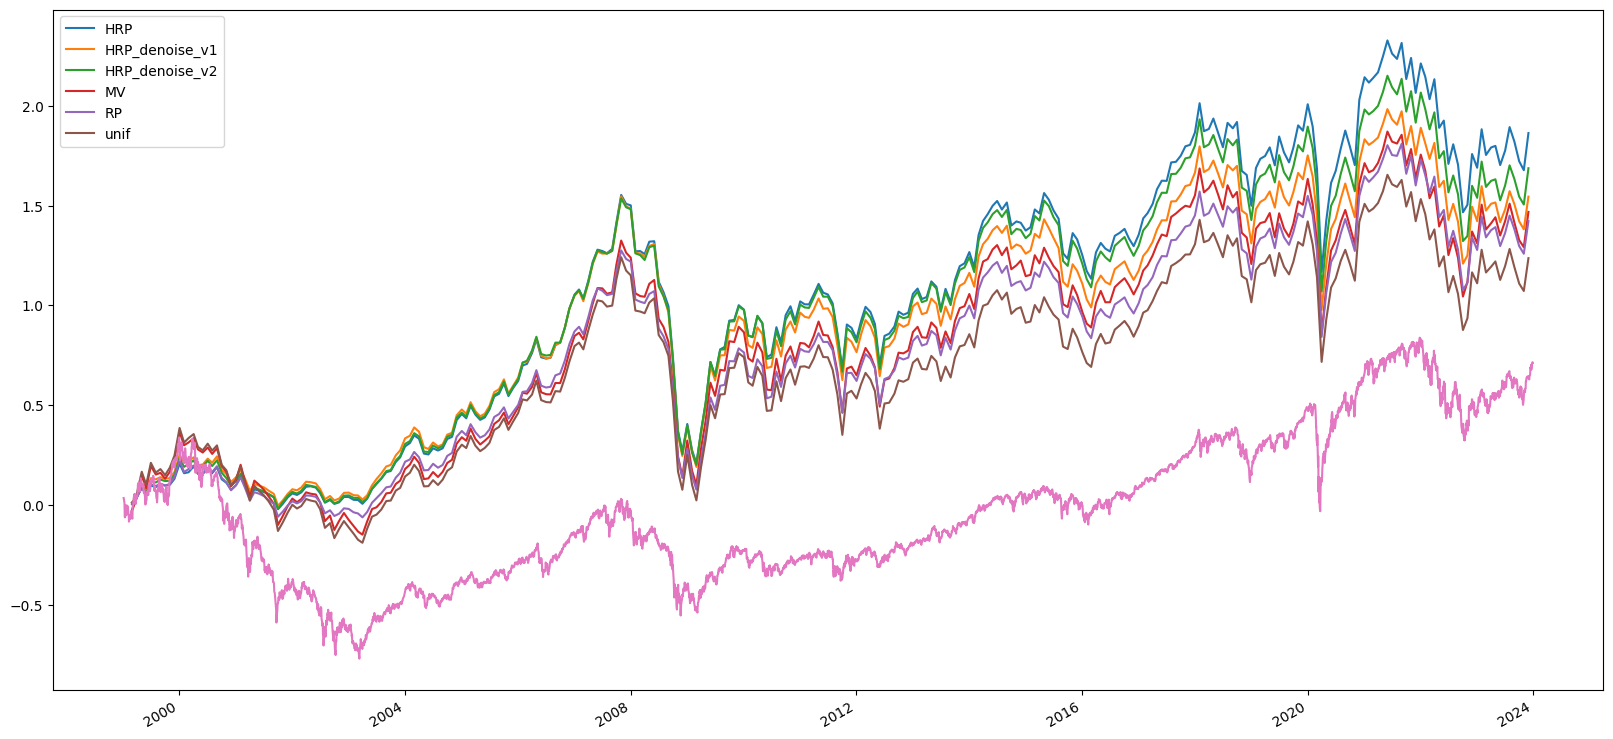

In [25]:
df_portfolio_monthly = df_portfolio[~df_portfolio.index.to_period('M').duplicated()]
portfolio_returns = df_portfolio_monthly.pct_change().dropna()
cumulative_returns = ((portfolio_returns + 1).cumprod() - 1)
cumulative_returns.plot(figsize=(20, 10))

benchmark_returns_without_first_day = benchmark_returns[benchmark_returns.index.to_period('M').duplicated()]
benchmark_cumulative_returns = ((benchmark_returns_without_first_day + 1).cumprod() - 1)
benchmark_cumulative_returns.plot()

### Testing simple monthly rebalancing with new capital each month

In [8]:
def get_portfolios_daily_returns(prices, weights, benchmark_ret):
    portfolios_daily_returns = pd.DataFrame(columns=weights.columns)
    for m in range(weights.shape[1]):
        weights_method = weights.iloc[:, m]
        
        # Restarting each period with 100 000 euros
        num_part = (100000*weights_method)/prices.iloc[0]
        portfolio = prices.mul(num_part).sum(axis=1)

        portfolio_ret = portfolio.pct_change()
        portfolios_daily_returns[weights_method.name] = portfolio_ret

    portfolios_daily_returns['Benchmark'] = benchmark_ret

    portfolios_daily_returns = portfolios_daily_returns.dropna()
    return portfolios_daily_returns

In [10]:
methods = ['HRP', 'HRP_denoise_v1', 'HRP_denoise_v2', 
           'MV', 'RP', 'unif', 'Benchmark']
monthly_returns = pd.DataFrame(columns=methods)
monthly_volatility = pd.DataFrame(columns=methods)
monthly_sharpe = pd.DataFrame(columns=methods)

for p in range(len(periods)-1):
    if p > periods.index('2022-03'):
        returns_fit = df_returns.loc[periods[p]].drop(columns='Russia')
        weights = get_weights(returns_fit)
        weights.loc['Russia', :] = 0
        weights = weights.sort_index()
    else:
        returns_fit = df_returns.loc[periods[p]]
        weights = get_weights(returns_fit)

    prices_period = df_prices.loc[periods[p+1]]
    benchmark_returns_period = benchmark_returns.loc[periods[p+1]]
    portfolios_daily_returns = get_portfolios_daily_returns(
        prices_period, weights, benchmark_returns_period)

    m_returns = (portfolios_daily_returns + 1).prod() - 1
    m_volatility = portfolios_daily_returns.std()*np.sqrt(22)

    monthly_returns.loc[periods[p+1]] = m_returns
    monthly_volatility.loc[periods[p+1]] = m_volatility
    monthly_sharpe.loc[periods[p+1]] = m_returns/m_volatility

<Axes: >

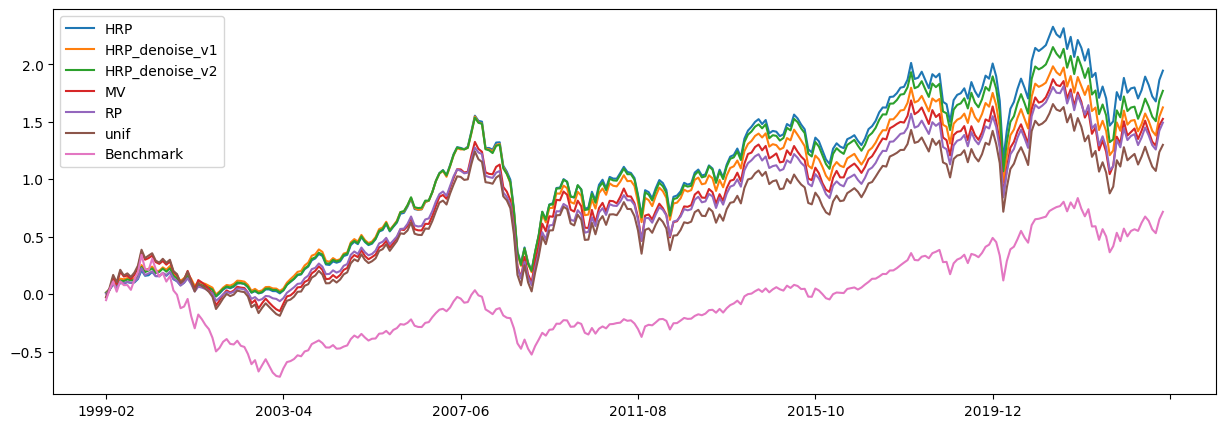

In [11]:
cumulative_returns = ((monthly_returns + 1).cumprod() - 1)
cumulative_returns.plot(figsize=(15, 5))

In [12]:
monthly_volatility.mean()

HRP               0.039704
HRP_denoise_v1    0.039875
HRP_denoise_v2    0.039903
MV                0.048953
RP                0.041290
unif              0.049959
Benchmark         0.060679
dtype: float64

In [13]:
monthly_sharpe.mean()

HRP               0.310708
HRP_denoise_v1    0.300718
HRP_denoise_v2    0.305836
MV                0.240305
RP                0.279553
unif              0.232131
Benchmark         0.260810
dtype: float64

### Testing simple yearly rebalancing

In [9]:
years = list(np.arange(df_prices.index[0].year, df_prices.index[-1].year))
methods = ['HRP', 'HRP_denoise_v1', 'HRP_denoise_v2', 
           'MV', 'RP', 'unif', 'Benchmark']

results_returns = pd.DataFrame(columns=methods)
results_volatility = pd.DataFrame(columns=methods)
results_sharpe = pd.DataFrame(columns=methods)

for y in years:
    returns_fit = df_returns.loc[str(y)]
    weights = get_weights(returns_fit)

    prices_year = df_prices.loc[str(y+1)]    
    benchmark_year = benchmark_returns.loc[str(y+1)]
    portfolios_daily_returns = get_portfolios_daily_returns(
        prices_year, weights, benchmark_year)

    # daily_to_annual_returns(portfolios_daily_returns)
    annual_returns = (portfolios_daily_returns + 1).prod() - 1
    annual_volatility = portfolios_daily_returns.std()*np.sqrt(252)
    annual_sharpe = annual_returns/annual_volatility

    results_returns.loc[str(y+1)] = annual_returns
    results_volatility.loc[str(y+1)] = annual_volatility
    results_sharpe.loc[str(y+1)] = annual_sharpe

<Axes: >

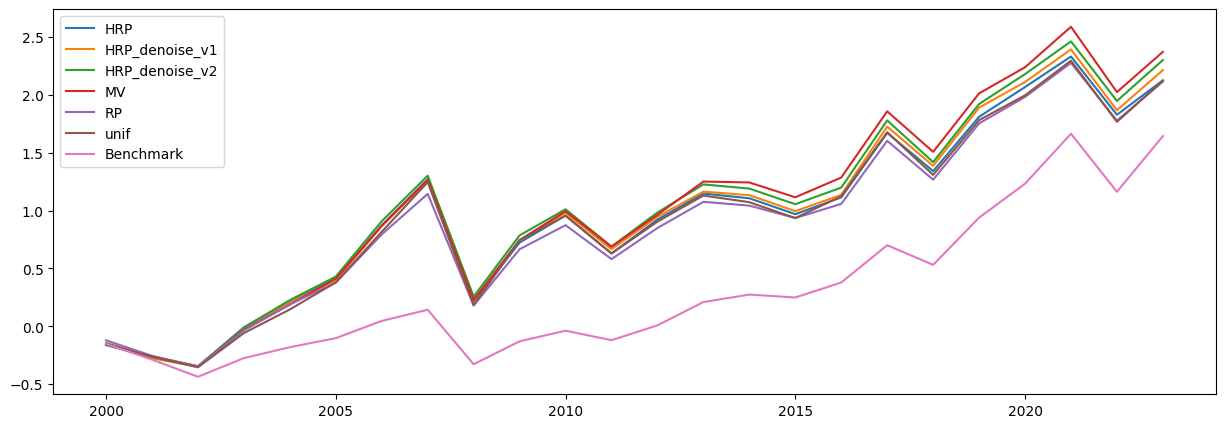

In [10]:
cumulative_yearly_returns = ((results_returns + 1).cumprod() - 1)
cumulative_yearly_returns.plot(figsize=(15, 5))

In [11]:
results_volatility.mean()

HRP               0.174287
HRP_denoise_v1    0.175558
HRP_denoise_v2    0.174783
MV                0.174790
RP                0.176932
unif              0.188501
Benchmark         0.170187
dtype: float64

In [12]:
results_sharpe.mean()

HRP               0.693777
HRP_denoise_v1    0.705306
HRP_denoise_v2    0.711177
MV                0.706708
RP                0.676734
unif              0.623403
Benchmark         0.668683
dtype: float64

### Comparing continuos investment vs restarting each month

<Axes: >

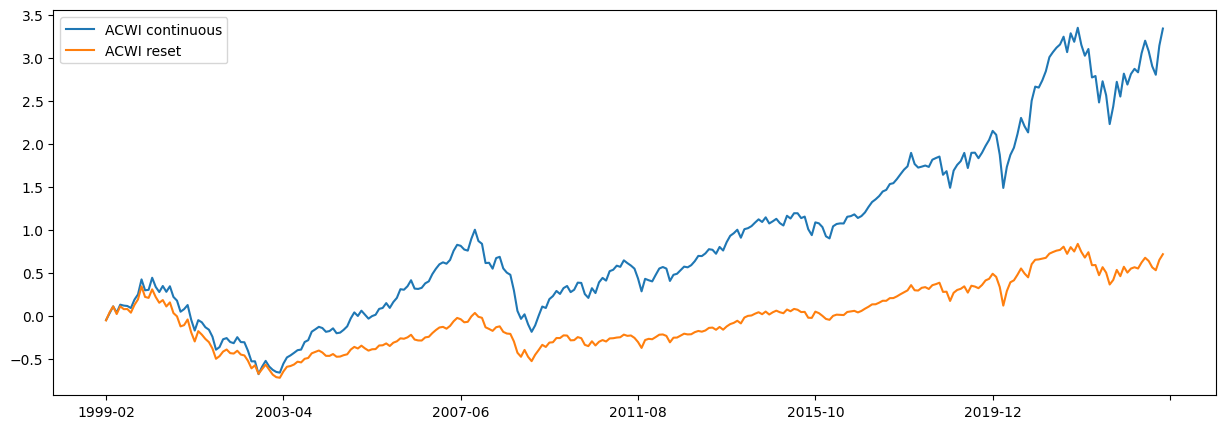

In [18]:
bench_ret = pd.DataFrame(columns=['ACWI continuous', 'ACWI reset'])

for p in range(len(periods)-1):
    benchmark_returns_period = benchmark_returns.loc[periods[p+1]]

    m_returns_cont = (benchmark_returns_period + 1).prod() - 1
    bench_ret.loc[periods[p+1],'ACWI continuous'] = m_returns_cont

    # Selling on the last day of the month and buying on the first
    # Basically 0% change on the first day each month
    m_returns_reset = (benchmark_returns_period[1:] + 1).prod() - 1
    bench_ret.loc[periods[p+1],'ACWI reset'] = m_returns_reset

cumulative_returns = ((bench_ret + 1).cumprod() - 1)
cumulative_returns.plot(figsize=(15, 5))

In [19]:
first_day_ret = benchmark_returns[~benchmark_returns.index.to_period('M').duplicated()]
first_day_ret

1999-01-05    0.019105
1999-02-01    0.003492
1999-03-01   -0.014055
1999-04-01    0.011270
1999-05-03    0.014517
                ...   
2023-08-01   -0.006942
2023-09-01    0.002798
2023-10-02   -0.004438
2023-11-01    0.009999
2023-12-01    0.007447
Name: ACWI, Length: 300, dtype: float64

In [20]:
returns_from_first_day_only = (first_day_ret + 1).prod() - 1
returns_from_first_day_only

1.5763379926434875

In [21]:
benchmark_returns_without_first_day = benchmark_returns[benchmark_returns.index.to_period('M').duplicated()]
benchmark_returns_without_first_day

1999-01-06    0.035491
1999-01-07   -0.004912
1999-01-08   -0.001886
1999-01-11   -0.016343
1999-01-12   -0.031972
                ...   
2023-12-22    0.001485
2023-12-26    0.004843
2023-12-27    0.002852
2023-12-28    0.000000
2023-12-29   -0.001863
Name: ACWI, Length: 5988, dtype: float64

In [22]:
returns_without_first_day = (benchmark_returns_without_first_day + 1).prod() - 1
returns_without_first_day

0.7121175374394029

In [23]:
full_returns = (benchmark_returns + 1).prod() - 1
full_returns

3.4109934595763507